# Feature Importance -- Deeplift

## Load and perpare data

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
# np.random.seed(12345) # Set seed

# import Query as query
import pandas as pd
from imblearn.combine import SMOTEENN 
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.utils import resample
from keras.layers import Dense,BatchNormalization,Input,Convolution1D,GRU,Dropout
#from keras.models import Model
import keras
#import pdb
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score
import warnings
import matplotlib.pyplot as plt
import deeplift

Using TensorFlow backend.


In [2]:
keras.__version__

'1.2.2'

data obtained earlier using Michael's code:

In [3]:
collapsed_shifted = pd.read_csv('collapsed_shifted.csv',index_col=0)
event_idx = pd.read_csv('event_idx.csv',header=None,index_col=0)
event_idx = np.array(event_idx).flatten()

In [4]:
# collapsed_shifted = pd.read_csv('collapsed_shifted.csv',index_col=0)
# event_idx = pd.read_csv('event_idx.csv',header=None,index_col=0)

In [5]:
print ('Creating train test split...')
X_train,X_test,Y_train,Y_test = train_test_split(collapsed_shifted,event_idx,stratify=None,test_size=.20,shuffle=False)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=.20,stratify=None,shuffle=False)

#Creating Copies of Data Frames these will be useful later for debugging
X_train_df = X_train.copy(True)
Y_train_df = Y_train.copy(True)
Y_val_df = Y_val.copy(True)
X_train  = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

Creating train test split...


/home/ubuntu/src/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/home/ubuntu/src/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


In [6]:
#pca = PCA(whiten=True)
#X_train = pca.fit_transform(X_train)
#X_test = pca.transform(X_test)
#X_val = pca.transform(X_val)

print ('Length of X_train before smote')
print (len(X_train))
print ('Number of Positives before smote')
print (Y_train.sum())


print ('Performing Oversampling/Undersampling...')
s = SMOTEENN()
X_train,Y_train= s.fit_sample(X_train,Y_train)

print ('Length of X_train after smote')
print (len(X_train))

print ('Number of Positive samples after smote')
print (Y_train.sum())

# print ('Proportion after smote {}'.format(sum(Y_train)/len(Y_train))

X_train = X_train.reshape(-1,X_train.shape[1],1)
X_test = X_test.reshape(-1,X_test.shape[1],1)
X_val = X_val.reshape(-1,X_val.shape[1],1)
print ('Done!')

Length of X_train before smote
2779
Number of Positives before smote
166
Performing Oversampling/Undersampling...
Length of X_train after smote
4580
Number of Positive samples after smote
2580
Done!


## Keras Model

Rewrite it to be compatiable with Deeplift.

There is no MaxoutDense in the Deeplift conversion part, so I skipped them for now.

In [7]:
#from keras.regularizers import l1l2
from keras.constraints import maxnorm
from keras.layers import MaxoutDense
from keras.layers import Flatten
from keras.layers import MaxPooling1D

def simple_keras_model(original):
    model = Sequential()
    model.add(Convolution1D(512, 5, border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5),input_shape =(original.shape[1],1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())
    model.add(Dropout(.55))
    model.add(Convolution1D(512,5,border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())
    model.add(Dropout(.55))
    model.add(Convolution1D(256,5,border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5)))
    model.add(BatchNormalization())
    model.add(Dropout(.55))
    model.add(Convolution1D(128,5,border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5)))
    model.add(BatchNormalization())
    model.add(Dropout(.55))
    model.add(Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(.35))
    model.add(Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(.35))
    model.add(Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(.35))
    model.add(Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(.35))
    
    
    
    model.add(Flatten())
    model.add(Dense(1024,activation='relu',init='he_normal'))
    model.add(Dense(512,activation='relu',init='he_normal'))
    model.add(Dense(128,activation='relu',init='he_normal'))
    
    model.add(Dense(2,activation='softmax'))
    
    
    #my_model = Model([original_input], output=output)
    optimizer_adam = keras.optimizers.adam(0.001) 
    model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['accuracy'])

    return(model)


In [8]:
Y_train = keras.utils.np_utils.to_categorical(nb_classes=2,y=Y_train)

In [9]:
import tensorflow as tf
from keras.models import Sequential
my_model = simple_keras_model(X_train)
my_model.fit(X_train,Y_train,nb_epoch=50 ,batch_size=128)

Epoch 1/50
4580/4580 [==============================] - 5s - loss: 0.7547 - acc: 0.6345     
Epoch 2/50
4580/4580 [==============================] - 1s - loss: 0.5217 - acc: 0.7430     
Epoch 3/50
4580/4580 [==============================] - 1s - loss: 0.4703 - acc: 0.7734     
Epoch 4/50
4580/4580 [==============================] - 1s - loss: 0.4451 - acc: 0.7934     
Epoch 5/50
4580/4580 [==============================] - 1s - loss: 0.3903 - acc: 0.8308     
Epoch 6/50
4580/4580 [==============================] - 1s - loss: 0.3542 - acc: 0.8544     
Epoch 7/50
4580/4580 [==============================] - 1s - loss: 0.3051 - acc: 0.8729     
Epoch 8/50
4580/4580 [==============================] - 1s - loss: 0.2875 - acc: 0.8869     
Epoch 9/50
4580/4580 [==============================] - 1s - loss: 0.2620 - acc: 0.8956     
Epoch 10/50
4580/4580 [==============================] - 1s - loss: 0.2345 - acc: 0.9066     
Epoch 11/50
4580/4580 [==============================] - 1s - loss: 0

In [10]:
my_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_1 (Convolution1D)  (None, 18, 512)       3072        convolution1d_input_1[0][0]      
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 18, 512)       2048        convolution1d_1[0][0]            
____________________________________________________________________________________________________
maxpooling1d_1 (MaxPooling1D)    (None, 9, 512)        0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 9, 512)        0           maxpooling1d_1[0][0]             
___________________________________________________________________________________________

## Deeplift

Adjusted from the code provided by the authors of the paper [https://arxiv.org/abs/1704.02685]:
https://github.com/kundajelab/deeplift/blob/tensorflow/deeplift/conversion/keras_conversion.py

In [11]:
import deeplift


In [12]:
#Convert a keras sequential model
import deeplift
from deeplift.conversion import keras_conversion as kc
#MxtsMode defines the method for computing importance scores. Other supported values are:
#Gradient, DeconvNet, GuidedBackprop and GuidedBackpropDeepLIFT (a hybrid of GuidedBackprop and DeepLIFT where
#negative multipliers are ignored during backpropagation)
deeplift_model = kc.convert_sequential_model(
                    my_model,
                    nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode.DeepLIFT)

#Specify the index of the layer to compute the importance scores of.
#In the example below, we find scores for the input layer, which is idx 0 in deeplift_model.get_layers()
find_scores_layer_idx = 0

#Compile the function that computes the importance scores
#For sigmoid or softmax outputs, target_layer_idx should be -2 (the default)
#(See "a note on final activation layers" in https://arxiv.org/pdf/1605.01713v2.pdf for justification)
#For regression tasks with a linear output, target_layer_idx should be -1
#(which simply refers to the last layer)
#FYI: In the case of MxtsMode.DeepLIFT, the importance scores are also called "contribution scores"
#If you want the multipliers instead of the contribution scores, you can use get_target_multipliers_func
deeplift_contribs_func = deeplift_model.get_target_contribs_func(
                            find_scores_layer_idx=find_scores_layer_idx,
                            target_layer_idx=-2)

#compute scores on inputs
#input_data_list is a list containing the data for different input layers
#eg: for MNIST, there is one input layer with with dimensions 1 x 28 x 28
#In the example below, let X be an array with dimension n x 1 x 28 x 28 where n is the number of examples
#task_idx represents the index of the node in the output layer that we wish to compute scores.
#Eg: if the output is a 10-way softmax, and task_idx is 0, we will compute scores for the first softmax class
scores = np.array(deeplift_contribs_func(task_idx=0,
                                         input_data_list=[X_train],
                                         batch_size=1,
                                         progress_update=1000))

No reference provided - using zeros
Done 0
Done 1000
Done 2000
Done 3000
Done 4000


In [13]:
s = scores.reshape([scores.shape[0],scores.shape[1]])

## Results

In [14]:
list(zip(X_train_df.columns,range(len(X_train_df.columns))))

[('GoldsteinScale', 0),
 ('numarticles', 1),
 ('NumMentions', 2),
 ('avgtone', 3),
 ('numsources', 4),
 ('wti_co', 5),
 ('unemploy', 6),
 ('m1v', 7),
 ('m2v', 8),
 ('slsi', 9),
 ('vix', 10),
 ('dff', 11),
 ('Open', 12),
 ('High', 13),
 ('Low', 14),
 ('Close', 15),
 ('Adj Close', 16),
 ('Volume', 17)]

Populating the interactive namespace from numpy and matplotlib


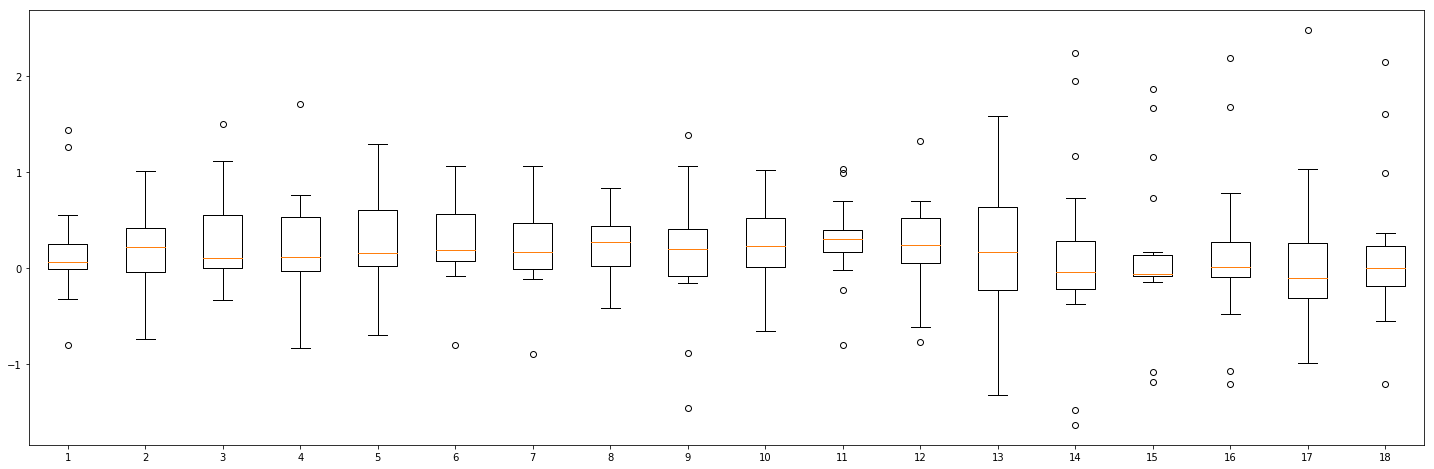

In [15]:
%pylab inline
pylab.rcParams['figure.figsize'] = (25, 8)

plt.figure()
data=[s[i] for i in range(18)]
plt.boxplot(data)
plt.show()

### Here is where there's an issue. Data is only 18x18? Should be  4576 x 18 see s in the next cell

In [16]:
np.array(data).shape

(18, 18)

In [17]:
np.array(s).shape

(4580, 18)

### This fixes the issue

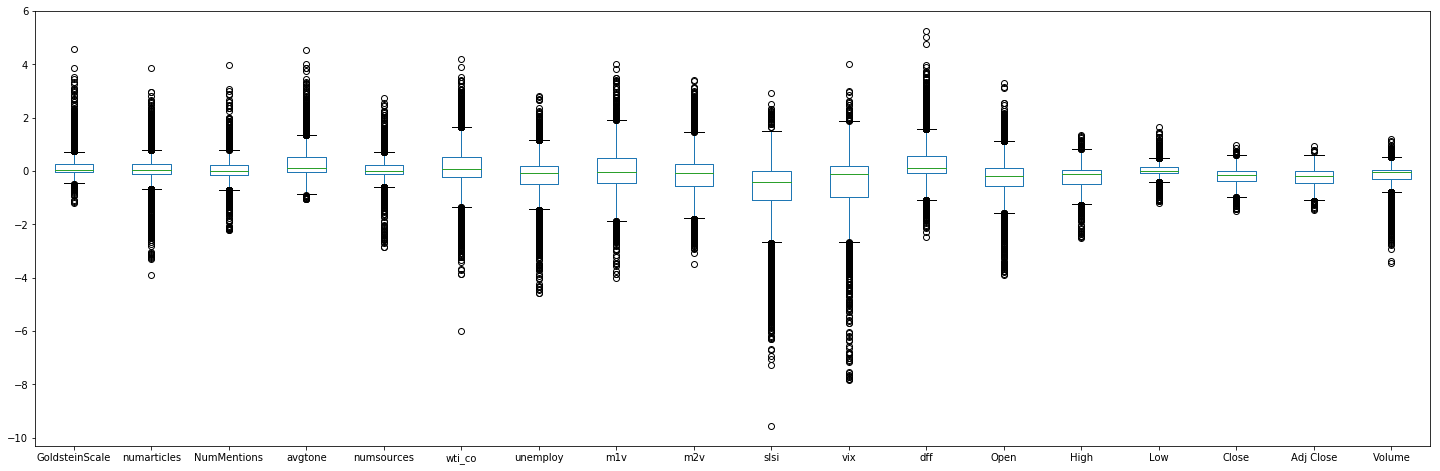

In [18]:
data = pd.DataFrame(s)
data.columns = X_train_df.columns
data.plot.box()


### Now we have positives and negatives so before we take the mean we want to take the abs before we take the mean in your code you were taking it after

In [19]:
## Using your code
mean_df = data.abs().mean()

In [20]:
mean_df.T.sort_values()

Low               0.169921
GoldsteinScale    0.267669
Close             0.270325
numsources        0.283104
NumMentions       0.294274
Adj Close         0.295935
Volume            0.296677
numarticles       0.369976
High              0.370433
avgtone           0.421786
dff               0.542056
Open              0.575153
m2v               0.587181
unemploy          0.598088
wti_co            0.630133
m1v               0.654186
vix               0.811479
slsi              1.002936
dtype: float32

It seems that sentiment features like 'GoldsteinScale' and 'avgtone' are more important than volume features. But finanical features like 'unemploy' and 'wit_co' are even more important than these sentiment metrics.